In [1]:
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# with the hyperparameter optimization for GNN results, calculate best model
cols = ['num', 'init_lr', 'dropout', 'hiddensize', 'ffn num layers', 'depth']
df = pd.DataFrame(columns = cols)

initlr = [1e-3, 1e-4] # initial learning rate
dropout = [0.1, 0.25, 0.4] # dropout rate
hiddensize = [300, 500, 1000, 1500] # size of each densely connected layer
ffnnumlayers = [1, 2] # number of densely connected layers
depth = [3, 4, 5] # number of graph convolutional operations

# loop through parameters and initialize a blank dataframe
model_dir = 0
for l in initlr:
    for d in dropout:
        for h in hiddensize:
            for f in ffnnumlayers:
                for de in depth:
                    new_row = [model_dir, l, d, h, f, de]
                    new = pd.DataFrame(new_row).T
                    new.columns = cols
                    df = pd.concat([df, new], ignore_index = True)   
                    model_dir = model_dir + 1
df

,num,init_lr,dropout,hiddensize,ffn num layers,depth
0,0.0,0.001,0.1,300.0,1.0,3.0
1,1.0,0.001,0.1,300.0,1.0,4.0
2,2.0,0.001,0.1,300.0,1.0,5.0
3,3.0,0.001,0.1,300.0,2.0,3.0
4,4.0,0.001,0.1,300.0,2.0,4.0
...,...,...,...,...,...,...
139,139.0,0.0001,0.4,1500.0,1.0,4.0
140,140.0,0.0001,0.4,1500.0,1.0,5.0
141,141.0,0.0001,0.4,1500.0,2.0,3.0
142,142.0,0.0001,0.4,1500.0,2.0,4.0


In [3]:
# initialize the best inhibition AUC, best killing AUC, and best AUC averaged between killing and inhibition
df['inh mean auc'] = [0] * len(df)
df['kill mean auc'] = [0] * len(df)
df['avg mean auc'] = [0] * len(df)
best_yet_kill = 0
best_yet_kill_index = ''
best_yet_inh = 0
best_yet_inh_index = ''
best_yet_avg = 0
best_yet_avg_index = ''

# loop through existing directory of files and grab metrics
for name in glob.glob('../models/hyperopt_gnn_models/**/test_scores.csv', recursive = True): 
    try:
        clean_num = int(name.split("hyperopt_gnn_models/")[1].split("/")[0])
    except Exception as e:
        print(e)
        print(name)
        continue
    new = pd.read_csv(name) 
    inh_mean_auc = float(list(new['Mean auc'])[0])
    kill_mean_auc = float(list(new['Mean auc'])[1])
    avg_auc = np.average([inh_mean_auc, kill_mean_auc])
    df.iloc[clean_num, df.columns.get_loc("inh mean auc")] = inh_mean_auc
    df.iloc[clean_num, df.columns.get_loc("kill mean auc")] = kill_mean_auc
    df.iloc[clean_num, df.columns.get_loc("avg mean auc")] = avg_auc

    if inh_mean_auc > best_yet_inh: # if this is the best result so far, keep it
        best_yet_inh = inh_mean_auc
        best_yet_inh_index = name
    if kill_mean_auc > best_yet_kill: # if this is the best result so far, keep it
        best_yet_kill = kill_mean_auc
        best_yet_kill_index = name
    if avg_auc > best_yet_avg: # if this is the best result so far, keep it
        best_yet_avg = avg_auc
        best_yet_avg_index = name

# print best metrics
print('best kill')
print(best_yet_kill)
print(best_yet_kill_index)

print('best inh')
print(best_yet_inh)
print(best_yet_inh_index)

print('best avg')
print(best_yet_avg)
print(best_yet_avg_index)

invalid literal for int() with base 10: 'finaltrain16'
../models/hyperopt_gnn_models/finaltrain16/test_scores.csv
best kill
0.8443814338675079
../models/hyperopt_gnn_models/16/test_scores.csv
best inh
0.898963771314707
../models/hyperopt_gnn_models/135/test_scores.csv
best avg
0.8711629401205153
../models/hyperopt_gnn_models/16/test_scores.csv


In [4]:
# let's look at the parameters of the best model
df.iloc[16,:]

num                   16.0
init_lr              0.001
dropout                0.1
hiddensize          1000.0
ffn num layers         2.0
depth                  4.0
inh mean auc      0.897944
kill mean auc     0.844381
avg mean auc      0.871163
Name: 16, dtype: object

In [5]:
# let's look at the parameters of another "best" model
df.iloc[135,:]

num                  135.0
init_lr             0.0001
dropout                0.4
hiddensize          1000.0
ffn num layers         2.0
depth                  3.0
inh mean auc      0.898964
kill mean auc     0.805738
avg mean auc      0.852351
Name: 135, dtype: object

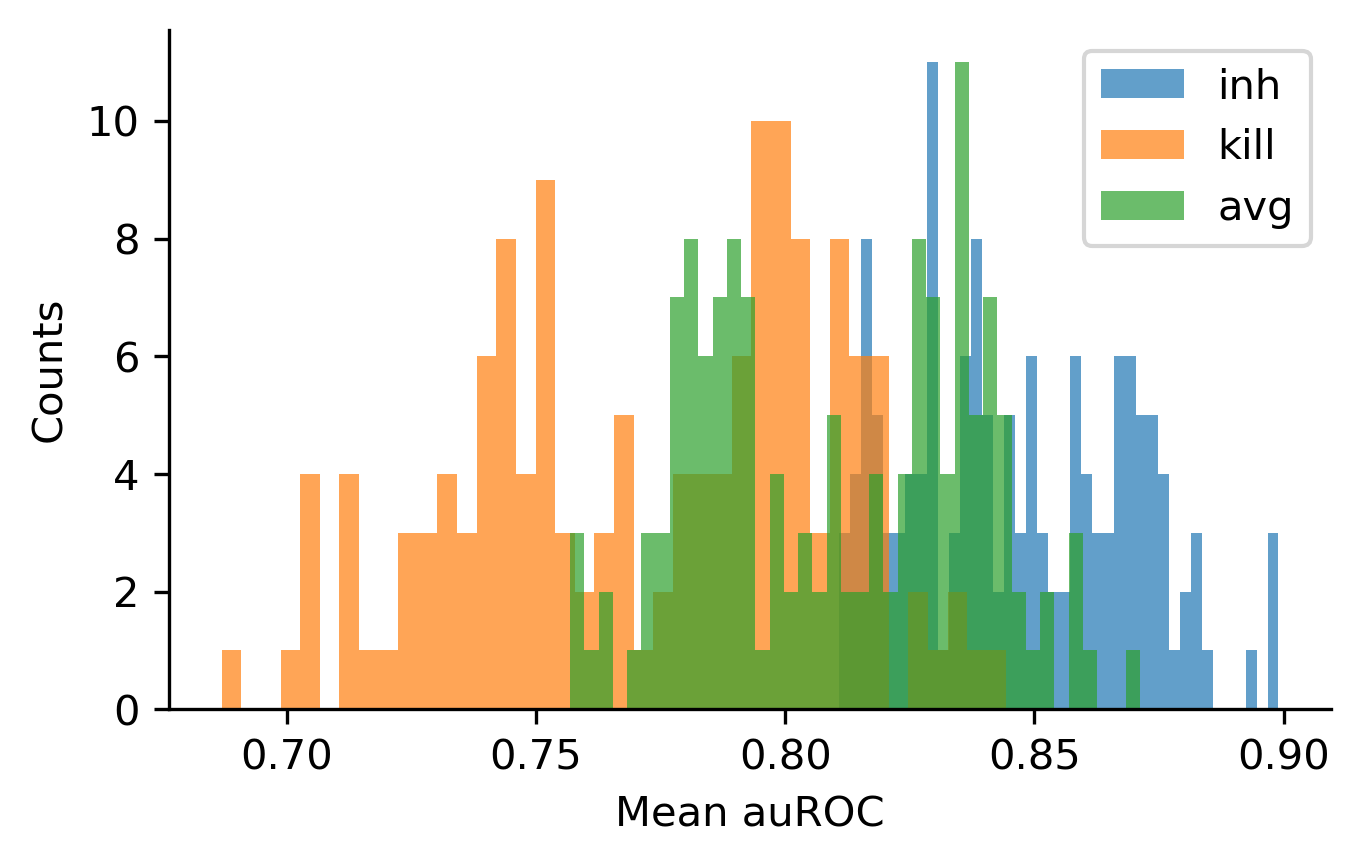

In [6]:
# let's plot the spread of AUC performance over the hyperparameter optimization
fig, ax = plt.subplots(figsize=(5,3), dpi = 300)
plt.hist(df['inh mean auc'], bins = 40, alpha = 0.7, label = 'inh')
plt.hist(df['kill mean auc'], bins = 40, alpha = 0.7, label = 'kill')
plt.hist(df['avg mean auc'], bins = 40, alpha = 0.7, label = 'avg')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Mean auROC')
plt.ylabel('Counts')
plt.legend()
plt.show()